## Case Study: Prediction of Loan Approval Prediction

Our new online bank seeks to automate (in real time) the loan qualifying procedure based on information given by customers while filling out an online application form. <br>
The data scientist team is approached to develop ML models that can help the company predict loan approval in accelerating decision-making process for determining whether an applicant is eligible for a loan or not. <br>

The following is the structure of the data set.<br>

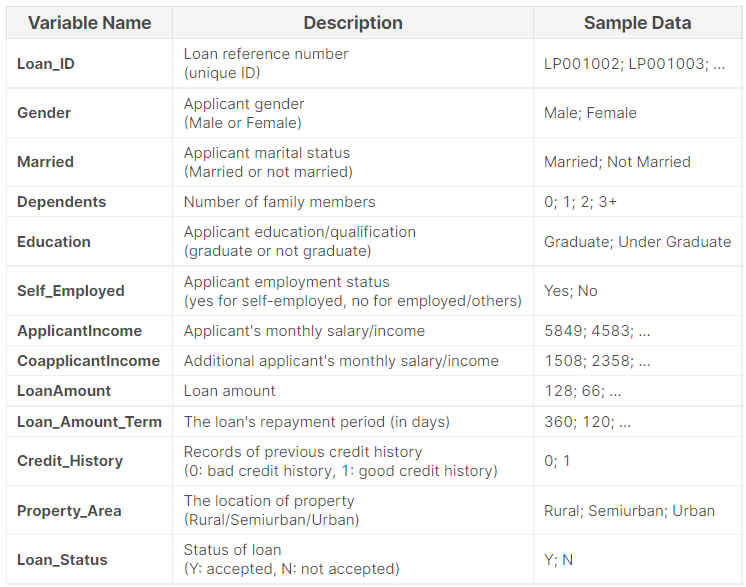

### Loading Libraries and Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn import svm
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/loan_prediction.csv')
df = df.drop(columns='Loan_ID')
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [4]:
# Change label for target column
df.replace({"Loan_Status":{'N':0,'Y':1}},inplace=True)
# Check spread of unique values in Loan Status
df['Loan_Status'].value_counts(normalize=True)

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64

In [5]:
# Initial correlation heatmap
df.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715,-0.004710
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056,-0.059187
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433,-0.037318
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470,-0.021268
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000,0.561678
Loan_Status,-0.004710,-0.059187,-0.037318,-0.021268,0.561678,1.000000


<AxesSubplot:>

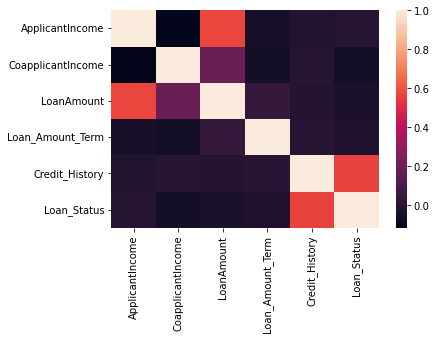

In [6]:
sns.heatmap(df.corr())

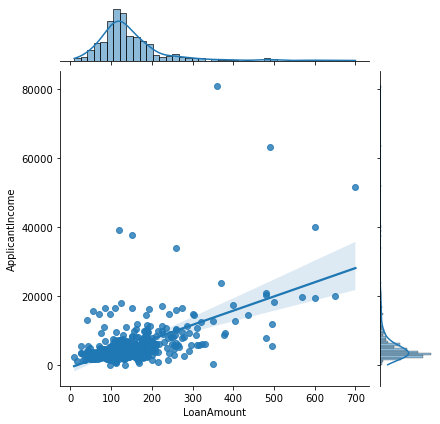

In [7]:
# Check correlation between Loan Amount & Applicant Income
sns.jointplot(x='LoanAmount', y='ApplicantIncome', data=df, kind='reg')

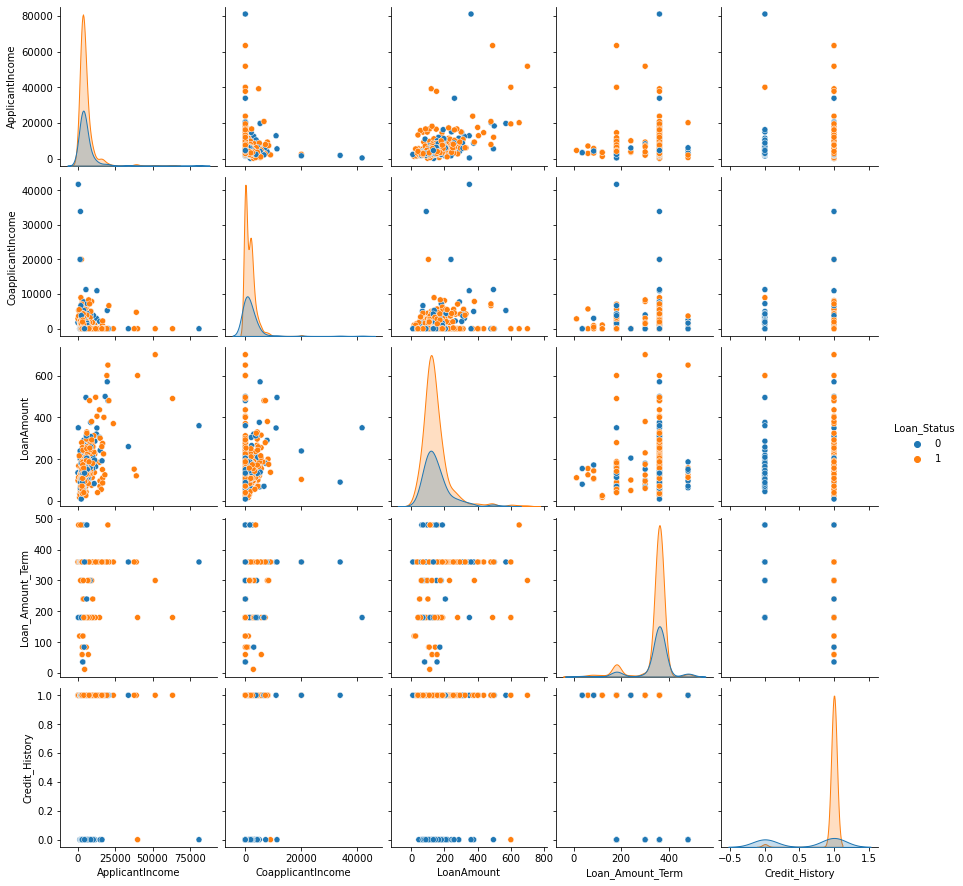

In [8]:
sns.pairplot(df, hue='Loan_Status')

In [9]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<AxesSubplot:xlabel='Dependents', ylabel='count'>

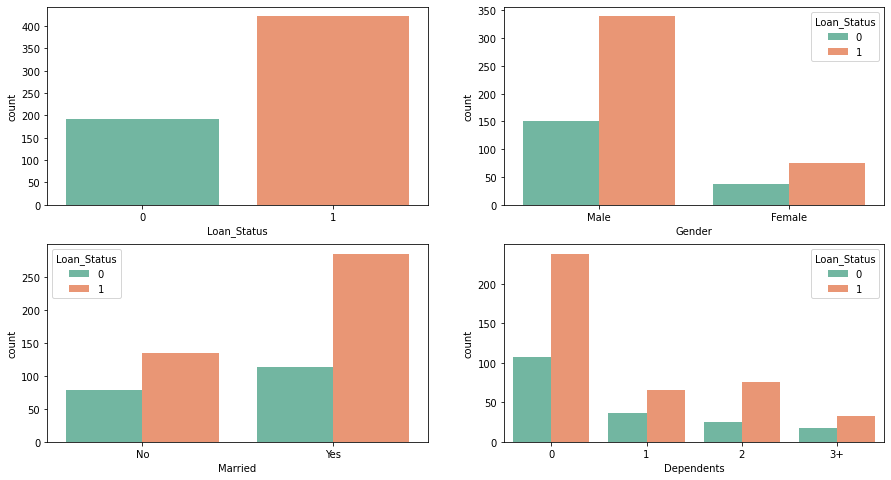

In [10]:
# DATA VISUALISATION
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,8))
fig.subplots_adjust(wspace=0.2)

sns.countplot(data=df, x=df["Loan_Status"], ax=ax1, palette='Set2')
sns.countplot(data=df, x=df["Gender"], hue='Loan_Status', ax=ax2, palette='Set2')
sns.countplot(data=df, x=df["Married"], hue='Loan_Status', ax=ax3, palette='Set2')
sns.countplot(data=df, x=df["Dependents"], hue='Loan_Status', ax=ax4, palette='Set2')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [12]:
# Summary of column count as % of total of the column
print(df['Gender'].value_counts(dropna=False))
print("Percentage of Male applicant: {:.2f}%".format(df['Gender'].value_counts(dropna=False)[0]/len(df['Gender'])*100))
print("Percentage of Female applicant: {:.2f}%".format(df['Gender'].value_counts(dropna=False)[1]/len(df['Gender'])*100))
print("Percentage of Null Gender applicant: {:.2f}%".format(df['Gender'].isnull().sum()/len(df['Gender'])*100))

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64
Percentage of Male applicant: 79.64%
Percentage of Female applicant: 18.24%
Percentage of Null Gender applicant: 2.12%


In [13]:
print(df['Married'].value_counts(dropna=False))
print("Percentage of Married applicant: {:.2f}%".format(df['Married'].value_counts(dropna=False)[0]/len(df['Married'])*100))
print("Percentage of not Married applicant: {:.2f}%".format(df['Married'].value_counts(dropna=False)[1]/len(df['Married'])*100))
print("Percentage of Null Married applicant: {:.2f}%".format(df['Married'].isnull().sum()/len(df['Married'])*100))

Yes    398
No     213
NaN      3
Name: Married, dtype: int64
Percentage of Married applicant: 64.82%
Percentage of not Married applicant: 34.69%
Percentage of Null Married applicant: 0.49%


In [14]:
print(df['Dependents'].value_counts(dropna=False))
print("Percentage of 0 Dependents: {:.2f}%".format(df['Dependents'].value_counts(dropna=False)[0]/len(df['Dependents'])*100))
print("Percentage of 1 Dependents: {:.2f}%".format(df['Dependents'].value_counts(dropna=False)[1]/len(df['Dependents'])*100))
print("Percentage of 2 Dependents: {:.2f}%".format(df['Dependents'].value_counts(dropna=False)[2]/len(df['Dependents'])*100))
print("Percentage of 3+ Dependents: {:.2f}%".format(df['Dependents'].value_counts(dropna=False)[3]/len(df['Dependents'])*100))
print("Percentage of Null Dependents: {:.2f}%".format(df['Dependents'].isnull().sum()/len(df['Dependents'])*100))

0      345
1      102
2      101
3+      51
NaN     15
Name: Dependents, dtype: int64
Percentage of 0 Dependents: 56.19%
Percentage of 1 Dependents: 16.61%
Percentage of 2 Dependents: 16.45%
Percentage of 3+ Dependents: 8.31%
Percentage of Null Dependents: 2.44%


<AxesSubplot:xlabel='Property_Area', ylabel='count'>

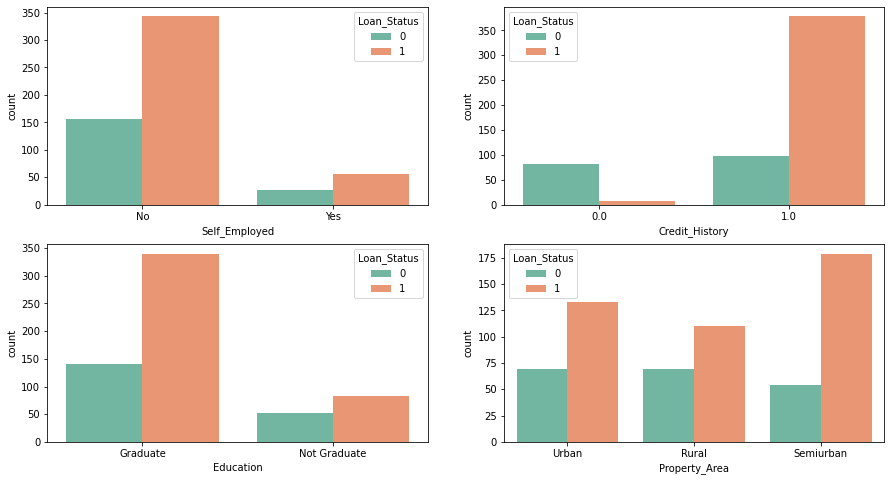

In [15]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,8))
fig.subplots_adjust(wspace=0.2)

sns.countplot(data=df, x=df["Self_Employed"], hue='Loan_Status', ax=ax1, palette='Set2')
sns.countplot(data=df, x=df["Credit_History"], hue='Loan_Status', ax=ax2, palette='Set2')
sns.countplot(data=df, x=df["Education"], hue='Loan_Status', ax=ax3, palette='Set2')
sns.countplot(data=df, x=df["Property_Area"], hue='Loan_Status', ax=ax4, palette='Set2')

In [16]:
print(df['Self_Employed'].value_counts(dropna=False))
print("Percentage of Self_Employed: {:.2f}%".format(df['Self_Employed'].value_counts(dropna=False)[0]/len(df['Self_Employed'])*100))
print("Percentage of Not Self_Employed: {:.2f}%".format(df['Self_Employed'].value_counts(dropna=False)[1]/len(df['Self_Employed'])*100))
print("Percentage of Null Self_Employed: {:.2f}%".format(df['Self_Employed'].isnull().sum()/len(df['Self_Employed'])*100))

No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64
Percentage of Self_Employed: 81.43%
Percentage of Not Self_Employed: 13.36%
Percentage of Null Self_Employed: 5.21%


In [17]:
print(df['Credit_History'].value_counts(dropna=False))
print("Percentage of Good Credit_History: {:.2f}%".format(df['Credit_History'].value_counts(dropna=False)[0]/len(df['Credit_History'])*100))
print("Percentage of Not Good Credit_History: {:.2f}%".format(df['Credit_History'].value_counts(dropna=False)[1]/len(df['Credit_History'])*100))
print("Percentage of Null Credit_History: {:.2f}%".format(df['Credit_History'].isnull().sum()/len(df['Credit_History'])*100))

1.0    475
0.0     89
NaN     50
Name: Credit_History, dtype: int64
Percentage of Good Credit_History: 14.50%
Percentage of Not Good Credit_History: 77.36%
Percentage of Null Credit_History: 8.14%


In [18]:
print(df['Education'].value_counts(dropna=False))
print("Percentage of Graduate: {:.2f}%".format(df['Education'].value_counts(dropna=False)[0]/len(df['Education'])*100))
print("Percentage of Not Graduate: {:.2f}%".format(df['Education'].value_counts(dropna=False)[1]/len(df['Education'])*100))
print("Percentage of Null Graduate: {:.2f}%".format(df['Education'].isnull().sum()/len(df['Education'])*100))

Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Percentage of Graduate: 78.18%
Percentage of Not Graduate: 21.82%
Percentage of Null Graduate: 0.00%


In [19]:
print(df['Property_Area'].value_counts(dropna=False))
print("Percentage of Semiurban: {:.2f}%".format(df['Property_Area'].value_counts(dropna=False)[0]/len(df['Property_Area'])*100))
print("Percentage of Urban: {:.2f}%".format(df['Property_Area'].value_counts(dropna=False)[1]/len(df['Property_Area'])*100))
print("Percentage of Rural: {:.2f}%".format(df['Property_Area'].value_counts(dropna=False)[2]/len(df['Property_Area'])*100))

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Percentage of Semiurban: 37.95%
Percentage of Urban: 32.90%
Percentage of Rural: 29.15%


<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Count'>

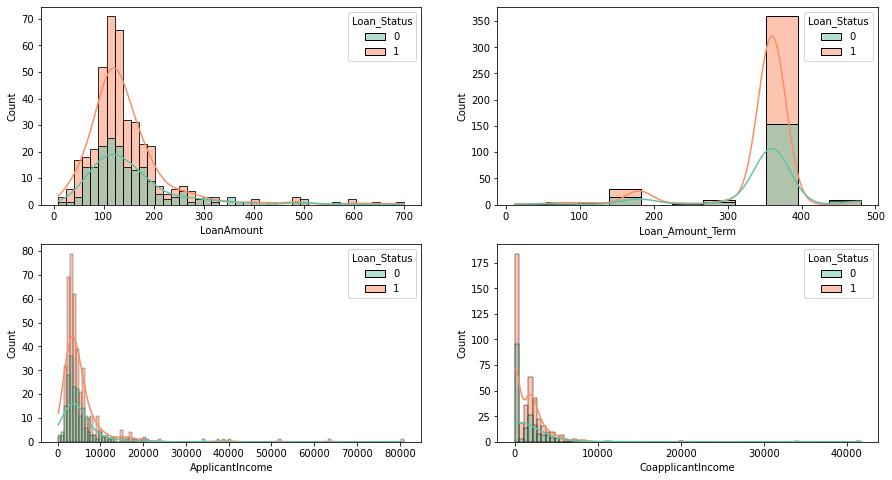

In [20]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,8))
fig.subplots_adjust(wspace=0.2)

sns.histplot(data=df, x=df["LoanAmount"], hue='Loan_Status', kde=True, ax=ax1, palette='Set2')
sns.histplot(data=df, x=df["Loan_Amount_Term"], hue='Loan_Status', kde=True, ax=ax2, palette='Set2')
sns.histplot(data=df, x=df["ApplicantIncome"], hue='Loan_Status', kde=True, ax=ax3, palette='Set2')
sns.histplot(data=df, x=df["CoapplicantIncome"], hue='Loan_Status', kde=True, ax=ax4, palette='Set2')

In [21]:
df['Loan_Amount_Term'].value_counts(dropna=False)

360.0    512
180.0     44
480.0     15
NaN       14
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [22]:
df[['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']].describe()

,LoanAmount,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome
count,592.000000,600.00000,614.000000,614.000000
mean,146.412162,342.00000,5403.459283,1621.245798
std,85.587325,65.12041,6109.041673,2926.248369
min,9.000000,12.00000,150.000000,0.000000
25%,100.000000,360.00000,2877.500000,0.000000
50%,128.000000,360.00000,3812.500000,1188.500000
75%,168.000000,360.00000,5795.000000,2297.250000
max,700.000000,480.00000,81000.000000,41667.000000


In [23]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [24]:
# IMPUTATION OF NULL VALUES with CORRELATION
# Level 1: LoanAmount is highly correlated to ApplicantIncome
df['LoanAmount'] = df.groupby('ApplicantIncome')['LoanAmount'].transform(lambda x: x.fillna(x.mean()))
# Level 2: LoanAmount is highly correlated to CoapplicantIncome
df['LoanAmount'] = df.groupby('CoapplicantIncome')['LoanAmount'].transform(lambda x: x.fillna(x.mean()))
# Level 3: impute remaining null cells by overall mean
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean()) 

# credit history is highly correlated to loan_status.
df['Credit_History'] = df.groupby('Loan_Status')['Credit_History'].transform(lambda x: x.fillna(x.mode()[0]))

In [25]:
# no major correlation hence impute based on dataset mode
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0]) 
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0]) 
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0]) 

In [26]:
df.isnull().sum()

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [27]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,145.045977,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


In [28]:
# https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
#Apply one hot encoding to non ordinal columns - Gender, Married, Education, Self_Employed
df = pd.get_dummies(df, columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area' ], 
                    drop_first=True)
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,145.045977,360.0,1.0,1,1,0,0,0,0,1
1,1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,0,0,0
2,0,3000,0.0,66.000000,360.0,1.0,1,1,1,0,1,0,1
3,0,2583,2358.0,120.000000,360.0,1.0,1,1,1,1,0,0,1
4,0,6000,0.0,141.000000,360.0,1.0,1,1,0,0,0,0,1


In [29]:
df.isnull().sum()

Dependents                 15
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  0
Loan_Amount_Term            0
Credit_History              0
Loan_Status                 0
Gender_Male                 0
Married_Yes                 0
Education_Not Graduate      0
Self_Employed_Yes           0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

In [30]:
# Check Dependents column
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [31]:
# Amend the 3+ to 3
df['Dependents'] = df['Dependents'].replace("3+", 3)
df['Dependents'].value_counts()

0    345
1    102
2    101
3     51
Name: Dependents, dtype: int64

In [32]:
# Null records imputation
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0]) 
df.isnull().sum()

Dependents                 0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
Gender_Male                0
Married_Yes                0
Education_Not Graduate     0
Self_Employed_Yes          0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64

In [33]:
corr = df.corr()
corr_dp = np.round(corr, decimals=2)
corr_dp

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
ApplicantIncome,1.00,-0.12,0.57,-0.05,-0.02,-0.00,0.06,0.05,-0.14,0.13,-0.01,-0.00
CoapplicantIncome,-0.12,1.00,0.19,-0.06,0.01,-0.06,0.08,0.08,-0.06,-0.02,-0.03,0.02
LoanAmount,0.57,0.19,1.00,0.04,-0.00,-0.03,0.11,0.14,-0.17,0.12,-0.01,-0.04
Loan_Amount_Term,-0.05,-0.06,0.04,1.00,-0.00,-0.02,-0.07,-0.10,-0.07,-0.03,0.06,-0.09
Credit_History,-0.02,0.01,-0.00,-0.00,1.00,0.54,0.01,0.01,-0.07,-0.00,0.04,-0.02
Loan_Status,-0.00,-0.06,-0.03,-0.02,0.54,1.00,0.02,0.09,-0.09,-0.00,0.14,-0.04
Gender_Male,0.06,0.08,0.11,-0.07,0.01,0.02,1.00,0.36,0.05,-0.00,-0.11,0.03
Married_Yes,0.05,0.08,0.14,-0.10,0.01,0.09,0.36,1.00,0.01,0.00,0.01,0.00
Education_Not Graduate,-0.14,-0.06,-0.17,-0.07,-0.07,-0.09,0.05,0.01,1.00,-0.01,-0.04,-0.03
Self_Employed_Yes,0.13,-0.02,0.12,-0.03,-0.00,-0.00,-0.00,0.00,-0.01,1.00,0.01,-0.03


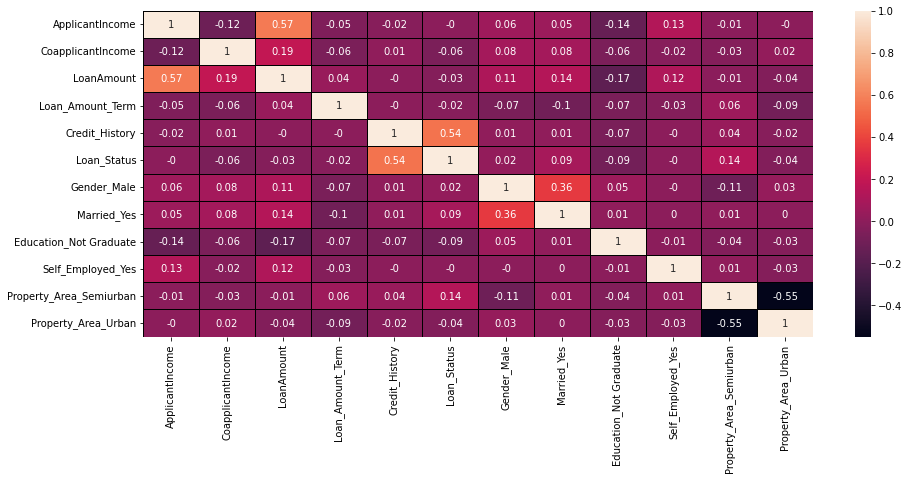

In [34]:
# Correlation heatmap
plt.figure(figsize=(15,6))
sns.heatmap(data=corr_dp, linewidths=1, linecolor='black',annot=True);

In [35]:
# Define X and y
X = df.drop(columns = 'Loan_Status')
y = df['Loan_Status']

### Feature Selection

In [36]:
from sklearn import linear_model
from sklearn.feature_selection import RFE

logreg_model = linear_model.LogisticRegression()

RFE = RFE(estimator=logreg_model, n_features_to_select=5, step=1)
RFE.fit(X, y)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [37]:
RFE.support_

array([False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True])

In [38]:
RFE.ranking_

array([4, 8, 7, 6, 5, 1, 3, 1, 1, 2, 1, 1])

In [39]:
feature_selected = X.columns[RFE.get_support()]
feature_selected

Index(['Credit_History', 'Married_Yes', 'Education_Not Graduate',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

In [40]:
# define new X with feature selected
X_new = df[feature_selected]
X_new.head(3)

,Credit_History,Married_Yes,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban
0,1.0,0,0,0,1
1,1.0,1,0,0,0
2,1.0,1,0,0,1


<AxesSubplot:>

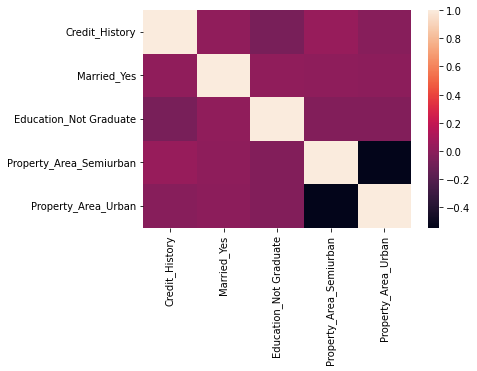

In [41]:
sns.heatmap(X_new.corr())

In [42]:
X.head(3)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,145.045977,360.0,1.0,1,0,0,0,0,1
1,1,4583,1508.0,128.000000,360.0,1.0,1,1,0,0,0,0
2,0,3000,0.0,66.000000,360.0,1.0,1,1,0,1,0,1


In [43]:
from sklearn.model_selection import cross_val_score
# Calculate accuracy scores with NEW features

initial_score = cross_val_score(logreg_model, X, y, cv=10, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))

fe_score = cross_val_score(logreg_model, X_new, y, cv=10, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.8063458487572712 
Accuracy after Feature Selection : 0.8095716552088842 


### Train Test Split - Scaling Data

In [44]:
#Splitting Data into Training and Test Sets, choose stratify to maintain X/Y ratio in splits
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=16, test_size = 0.20)

# Standardise data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Balance any imbalanced dataset 
#model = SMOTE(random_state =42)
#X_train, y_train = model.fit_resample(X_train, y_train)

# Check values of outcomes before and after to ensure SMOTE is successful
print(y_train.value_counts())

# Use this train set for all models below

1    344
0    147
Name: Loan_Status, dtype: int64


#### Model 1: Logistic Regression

In [45]:
# Make an instance of the Model
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

# predicted test probability:

y_pred = lr_model.predict(X_test)

y_proba_lr = lr_model.predict_proba(X_test)
y_proba_lr = y_proba_lr[:,1].reshape((y_proba_lr.shape[0],))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))
print(f'Training Accuracy Score: {lr_model.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {lr_model.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     1.0000    0.3778    0.5484        45
           1     0.7358    1.0000    0.8478        78

    accuracy                         0.7724       123
   macro avg     0.8679    0.6889    0.6981       123
weighted avg     0.8325    0.7724    0.7383       123

Training Accuracy Score: 0.8187372708757638
Testing Accuracy Score: 0.7723577235772358


In [46]:
# Confusion matrix for Logistic Regression:
lr_cm = metrics.confusion_matrix(y_test, y_pred)

modified_lr_cm = []
for index,value in enumerate(lr_cm):
    if index == 0:
        modified_lr_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_lr_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
modified_lr_cm

[['TN = 17', 'FP = 28'], ['FN = 0', 'TP = 78']]

#### Model 2: Support Vector Machine

In [47]:
from sklearn import svm
# Make an instance of the Model
svc_model = svm.SVC(probability=True)

# Training the model on the data
svc_model.fit(X_train, y_train)

# predict test class:
y_pred_svc = svc_model.predict(X_test)

# predicted test probability:
y_proba = svc_model.predict_proba(X_test)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svc, digits=4))
print(f'Training Accuracy Score: {svc_model.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {svc_model.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     1.0000    0.3778    0.5484        45
           1     0.7358    1.0000    0.8478        78

    accuracy                         0.7724       123
   macro avg     0.8679    0.6889    0.6981       123
weighted avg     0.8325    0.7724    0.7383       123

Training Accuracy Score: 0.8187372708757638
Testing Accuracy Score: 0.7723577235772358


In [49]:
# Confusion matrix for Support Vector Machine:
svm_cm = metrics.confusion_matrix(y_test, y_pred_svc)

modified_svm_cm = []
for index,value in enumerate(svm_cm):
    if index == 0:
        modified_svm_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_svm_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
modified_svm_cm

[['TN = 17', 'FP = 28'], ['FN = 0', 'TP = 78']]

#### Model 3: Naive Bayes

In [50]:
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB

# Make an instance of the Model
nb_model = GaussianNB()

# Training the model on the data
nb_model.fit(X_train, y_train)

# predict test class:
y_pred_nb = nb_model.predict(X_test)

# predicted test probability:
y_proba = nb_model.predict_proba(X_test)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nb, digits=4))
print(f'Training Accuracy Score: {nb_model.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {nb_model.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     1.0000    0.3778    0.5484        45
           1     0.7358    1.0000    0.8478        78

    accuracy                         0.7724       123
   macro avg     0.8679    0.6889    0.6981       123
weighted avg     0.8325    0.7724    0.7383       123

Training Accuracy Score: 0.8187372708757638
Testing Accuracy Score: 0.7723577235772358


In [52]:
# Confusion matrix:
nb_cm = metrics.confusion_matrix(y_test, y_pred_nb)

modified_nb_cm = []
for index,value in enumerate(nb_cm):
    if index == 0:
        modified_nb_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_nb_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
modified_nb_cm

[['TN = 17', 'FP = 28'], ['FN = 0', 'TP = 78']]

### Summaries of Models before Optimisation

0.7408831908831909
0.6844729344729344
0.7548433048433049


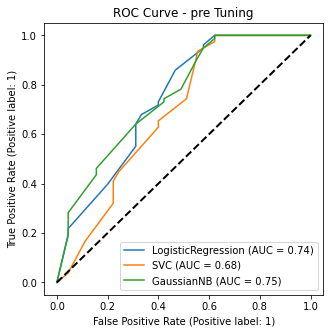

In [53]:
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_auc_score

plt.figure(figsize=(5,5))
ax=plt.subplot(111)
plot_roc_curve(lr_model, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(svc_model, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(nb_model, X_test, y_test, ax=ax)
plt.plot([0, 1], [0, 1], color = 'black', lw = 2, linestyle = '--')
plt.title("ROC Curve - pre Tuning")

print(roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, svc_model.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1]))

#### Gridsearch Optimal Parameters for All Models

<b>1. Find Best Estimator For Logistic Regression<b>

In [54]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 
}

In [55]:
from sklearn.model_selection import GridSearchCV

grid_lr = GridSearchCV(lr_model, lr_params, cv=10, verbose = 4, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END ................C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END ...............C=1e-05, penalty=l1;, score=nan total time=   0.0s
[CV 1/10] END ..............C=1e-05, penalty=l2;, score=0.753 total time=   0.0s
[CV 2/10] END ..............C=1e-05, penalty=l

[CV 10/10] END ................C=10, penalty=l2;, score=0.740 total time=   0.0s
[CV 1/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 6/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 7/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 8/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 9/10] END ..................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 10/10] END .................C=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/10] END ................C=100, penalty=l2;, score=0.797 total time=   0.0s
[CV 2/10] END ..............

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=4)

In [56]:
grid_lr.best_score_

0.777295318127251

In [57]:
grid_lr.best_params_

{'C': 1, 'penalty': 'l2'}

In [58]:
grid_lr.best_estimator_

LogisticRegression(C=1)

In [59]:
# Rerun based on based parameters
best_lr = LogisticRegression(C=1, penalty='l2')

# Fit the best model
best_lr.fit(X_train, y_train)

LogisticRegression(C=1)

In [60]:
best_lr_predictions = best_lr.predict(X_test)
print(classification_report(y_test,best_lr_predictions, digits=4))

print(f'Training Accuracy Score: {best_lr.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {best_lr.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     1.0000    0.3778    0.5484        45
           1     0.7358    1.0000    0.8478        78

    accuracy                         0.7724       123
   macro avg     0.8679    0.6889    0.6981       123
weighted avg     0.8325    0.7724    0.7383       123

Training Accuracy Score: 0.8187372708757638
Testing Accuracy Score: 0.7723577235772358


In [61]:
# Confusion matrix for Logistic Regression:
lr_cm_best = metrics.confusion_matrix(y_test, best_lr_predictions)

best_lr_cm = []
for index,value in enumerate(lr_cm_best):
    if index == 0:
        best_lr_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        best_lr_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        
best_lr_cm

[['TN = 17', 'FP = 28'], ['FN = 0', 'TP = 78']]

<b>2. Find Best Estimator For Support Vector Machine<b>

In [62]:
svc_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf'],
}

In [63]:
#find best hyper parameters for SVM/SVC
svc = svm.SVC(probability=True)
grid_svc = GridSearchCV(svc, svc_params, cv=10, scoring='roc_auc', verbose = 4)
grid_svc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.610 total time=   0.0s
[CV 2/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.628 total time=   0.0s
[CV 3/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.630 total time=   0.0s
[CV 4/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.627 total time=   0.0s
[CV 5/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.755 total time=   0.0s
[CV 6/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.666 total time=   0.0s
[CV 7/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.670 total time=   0.0s
[CV 8/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.673 total time=   0.0s
[CV 9/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.872 total time=   0.0s
[CV 10/10] END C=0.1, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/10] END ...C=0.1, gamma=0.001, kernel=rbf;, score=0.679 total time=   0.0s
[CV 2/10] END ...C=0.1, gamma=0.001, kernel=r

[CV 1/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.685 total time=   0.0s
[CV 2/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.715 total time=   0.0s
[CV 5/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.560 total time=   0.0s
[CV 6/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.906 total time=   0.0s
[CV 7/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.672 total time=   0.0s
[CV 8/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.623 total time=   0.0s
[CV 9/10] END ...C=10, gamma=0.0001, kernel=rbf;, score=0.749 total time=   0.0s
[CV 10/10] END ..C=10, gamma=0.0001, kernel=rbf;, score=0.775 total time=   0.0s
[CV 1/10] END C=100, gamma=0.001, kernel=linear;, score=0.603 total time=   0.0s
[CV 2/10] END C=100, gamma=0.001, kernel=linear;, score=0.762 total time=   0.0s
[CV 3/10] END C=100, gamma=0

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc', verbose=4)

In [64]:
grid_svc.best_score_

0.7680532212885154

In [65]:
grid_svc.best_params_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

In [66]:
grid_svc.best_estimator_

SVC(C=0.1, gamma=0.0001, probability=True)

In [67]:
# Rerun based on based parameters
best_svc = svm.SVC(C=0.1, gamma=0.0001, probability=True)

# Fit the best model
best_svc.fit(X_train, y_train)

SVC(C=0.1, gamma=0.0001, probability=True)

In [68]:
best_svc_predictions = best_svc.predict(X_test)
print(classification_report(y_test,best_svc_predictions, digits=4))

print(f'Training Accuracy Score: {best_svc.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {best_svc.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        45
           1     0.6341    1.0000    0.7761        78

    accuracy                         0.6341       123
   macro avg     0.3171    0.5000    0.3881       123
weighted avg     0.4021    0.6341    0.4922       123

Training Accuracy Score: 0.7006109979633401
Testing Accuracy Score: 0.6341463414634146


In [69]:
# Confusion matrix for Support Vector Machine:
svc_cm_best = metrics.confusion_matrix(y_test, best_svc_predictions)

best_svc_cm = []
for index,value in enumerate(svc_cm_best):
    if index == 0:
        best_svc_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        best_svc_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   
        

print(svc_cm_best)
print(best_svc_cm)

[[ 0 45]
 [ 0 78]]
[['TN = 0', 'FP = 45'], ['FN = 0', 'TP = 78']]


<b>3. Find Best Estimator For Gaussian Naive Bayes<b>

In [70]:
nb_params = {
    'var_smoothing': np.logspace(0,-9, num=100),
    }

In [71]:
#find best hyper parameters for Naive Bayes

grid_nb = GridSearchCV(nb_model, nb_params, scoring='roc_auc', cv=10, verbose = 4)
grid_nb.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10] END ................var_smoothing=1.0;, score=0.753 total time=   0.0s
[CV 2/10] END ................var_smoothing=1.0;, score=0.760 total time=   0.0s
[CV 3/10] END ................var_smoothing=1.0;, score=0.611 total time=   0.0s
[CV 4/10] END ................var_smoothing=1.0;, score=0.666 total time=   0.0s
[CV 5/10] END ................var_smoothing=1.0;, score=0.687 total time=   0.0s
[CV 6/10] END ................var_smoothing=1.0;, score=0.955 total time=   0.0s
[CV 7/10] END ................var_smoothing=1.0;, score=0.754 total time=   0.0s
[CV 8/10] END ................var_smoothing=1.0;, score=0.799 total time=   0.0s
[CV 9/10] END ................var_smoothing=1.0;, score=0.906 total time=   0.0s
[CV 10/10] END ...............var_smoothing=1.0;, score=0.728 total time=   0.0s
[CV 1/10] END .var_smoothing=0.8111308307896871;, score=0.753 total time=   0.0s
[CV 2/10] END .var_smoothing=0.8111308307896

[CV 6/10] END ................var_smoothing=0.1;, score=0.949 total time=   0.0s
[CV 7/10] END ................var_smoothing=0.1;, score=0.754 total time=   0.0s
[CV 8/10] END ................var_smoothing=0.1;, score=0.789 total time=   0.0s
[CV 9/10] END ................var_smoothing=0.1;, score=0.920 total time=   0.0s
[CV 10/10] END ...............var_smoothing=0.1;, score=0.728 total time=   0.0s
[CV 1/10] END var_smoothing=0.08111308307896872;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=0.08111308307896872;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=0.08111308307896872;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=0.08111308307896872;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=0.08111308307896872;, score=0.679 total time=   0.0s
[CV 6/10] END var_smoothing=0.08111308307896872;, score=0.949 total time=   0.0s
[CV 7/10] END var_smoothing=0.08111308307896872;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=

[CV 5/10] END var_smoothing=0.006579332246575682;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=0.006579332246575682;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=0.006579332246575682;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=0.006579332246575682;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=0.006579332246575682;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=0.006579332246575682;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=0.005336699231206307;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=0.005336699231206307;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=0.005336699231206307;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=0.005336699231206307;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=0.005336699231206307;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=0.005336699231206307;, score=0.943 total time=   0.0s
[CV 7/10] END v

[CV 7/10] END var_smoothing=0.0008111308307896872;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=0.0008111308307896872;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=0.0008111308307896872;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=0.0008111308307896872;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=0.0006579332246575676;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=0.0006579332246575676;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=0.0006579332246575676;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=0.0006579332246575676;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=0.0006579332246575676;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=0.0006579332246575676;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=0.0006579332246575676;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=0.0006579332246575676;, score=0.789 total time=   0.0s
[CV

[CV 1/10] END var_smoothing=5.3366992312063123e-05;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=5.3366992312063123e-05;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=5.3366992312063123e-05;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=5.3366992312063123e-05;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=5.3366992312063123e-05;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=5.3366992312063123e-05;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=5.3366992312063123e-05;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=5.3366992312063123e-05;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=5.3366992312063123e-05;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=5.3366992312063123e-05;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=4.328761281083062e-05;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=4.328761281083062e-05;, score=0.764 total time= 

[CV 10/10] END var_smoothing=8.111308307896873e-06;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=6.579332246575683e-06;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=6.579332246575683e-06;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=6.579332246575683e-06;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=6.579332246575683e-06;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=6.579332246575683e-06;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=6.579332246575683e-06;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=6.579332246575683e-06;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=6.579332246575683e-06;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=6.579332246575683e-06;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=6.579332246575683e-06;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=5.336699231206313e-06;, score=0.748 total time=   0.0s
[C

[CV 2/10] END var_smoothing=3.5111917342151277e-07;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=3.5111917342151277e-07;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=3.5111917342151277e-07;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=3.5111917342151277e-07;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=3.5111917342151277e-07;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=3.5111917342151277e-07;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=3.5111917342151277e-07;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=3.5111917342151277e-07;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=3.5111917342151277e-07;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=2.848035868435799e-07;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=2.848035868435799e-07;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=2.848035868435799e-07;, score=0.611 total time=  

[CV 6/10] END var_smoothing=4.3287612810830526e-08;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=4.3287612810830526e-08;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=4.3287612810830526e-08;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=4.3287612810830526e-08;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=4.3287612810830526e-08;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=3.5111917342151277e-08;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=3.5111917342151277e-08;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=3.5111917342151277e-08;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=3.5111917342151277e-08;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=3.5111917342151277e-08;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=3.5111917342151277e-08;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=3.5111917342151277e-08;, score=0.754 total time

[CV 1/10] END var_smoothing=3.5111917342151273e-09;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=3.5111917342151273e-09;, score=0.764 total time=   0.0s
[CV 3/10] END var_smoothing=3.5111917342151273e-09;, score=0.611 total time=   0.0s
[CV 4/10] END var_smoothing=3.5111917342151273e-09;, score=0.662 total time=   0.0s
[CV 5/10] END var_smoothing=3.5111917342151273e-09;, score=0.699 total time=   0.0s
[CV 6/10] END var_smoothing=3.5111917342151273e-09;, score=0.943 total time=   0.0s
[CV 7/10] END var_smoothing=3.5111917342151273e-09;, score=0.754 total time=   0.0s
[CV 8/10] END var_smoothing=3.5111917342151273e-09;, score=0.789 total time=   0.0s
[CV 9/10] END var_smoothing=3.5111917342151273e-09;, score=0.920 total time=   0.0s
[CV 10/10] END var_smoothing=3.5111917342151273e-09;, score=0.730 total time=   0.0s
[CV 1/10] END var_smoothing=2.848035868435805e-09;, score=0.748 total time=   0.0s
[CV 2/10] END var_smoothing=2.848035868435805e-09;, score=0.764 total time= 

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc', verbose=4)

In [72]:
grid_nb.best_score_

0.76265506202481

In [73]:
grid_nb.best_params_

{'var_smoothing': 0.008111308307896872}

In [74]:
grid_nb.best_estimator_

GaussianNB(var_smoothing=0.008111308307896872)

In [75]:
# Rerun based on based parameters
best_nb = GaussianNB(var_smoothing=0.008111308307896872)

# Fit the best model
best_nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.008111308307896872)

In [76]:
best_nb_predictions = best_nb.predict(X_test)
print(classification_report(y_test,best_nb_predictions, digits=4))

print(f'Training Accuracy Score: {best_nb.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {best_nb.score(X_test, y_test)}')

              precision    recall  f1-score   support

           0     1.0000    0.3778    0.5484        45
           1     0.7358    1.0000    0.8478        78

    accuracy                         0.7724       123
   macro avg     0.8679    0.6889    0.6981       123
weighted avg     0.8325    0.7724    0.7383       123

Training Accuracy Score: 0.8187372708757638
Testing Accuracy Score: 0.7723577235772358


In [77]:
# Confusion matrix for Naive Bayes:
nb_cm_best = metrics.confusion_matrix(y_test, best_nb_predictions)

best_nb_cm = []
for index,value in enumerate(nb_cm_best):
    if index == 0:
        best_nb_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        best_nb_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

print(nb_cm_best)
print(best_nb_cm)

[[17 28]
 [ 0 78]]
[['TN = 17', 'FP = 28'], ['FN = 0', 'TP = 78']]


###  ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

0.7408831908831909
0.7027065527065527
0.7548433048433049


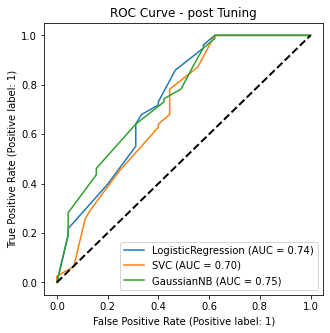

In [78]:
plt.figure(figsize=(5,5))
ax=plt.subplot(111)
plot_roc_curve(best_lr, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_svc, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_nb, X_test, y_test, ax=ax)
plt.plot([0, 1], [0, 1], color = 'black', lw = 2, linestyle = '--')
plt.title("ROC Curve - post Tuning")

print(roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, grid_svc.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, grid_nb.predict_proba(X_test)[:, 1]))

In [79]:
# CROSS VALIDATION SCORES - APPLY to TRAIN ONLY & TUNING HYPERPARAMETERS
from sklearn.model_selection import cross_val_score

print(cross_val_score(best_lr, X_train, y_train, cv=10))
print(cross_val_score(best_lr, X_train, y_train, cv=10).mean())

print(cross_val_score(best_svc, X_train, y_train, cv=10))
print(cross_val_score(best_svc, X_train, y_train, cv=10).mean())

print(cross_val_score(best_nb, X_train, y_train, cv=10))
print(cross_val_score(best_nb, X_train, y_train, cv=10).mean())

[0.82       0.83673469 0.79591837 0.79591837 0.7755102  0.87755102
 0.79591837 0.7755102  0.89795918 0.81632653]
0.8187346938775508
[0.7        0.71428571 0.71428571 0.71428571 0.69387755 0.69387755
 0.69387755 0.69387755 0.69387755 0.69387755]
0.7006122448979593
[0.82       0.83673469 0.79591837 0.79591837 0.7755102  0.87755102
 0.79591837 0.7755102  0.89795918 0.81632653]
0.8187346938775508
